<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 8th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

# Exercise 1

First, we read in the data from the respective files:

In [121]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as nprd
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML

def readfile(filename):
    """Opens file with given filename and reads in data line after line into a numpy array"""
    data = [[] for i in range(10)]
    f = open(filename)
    for line in f:
        ls = line.split(' ')
        digit = int(float(ls[0]))
        sample = np.array([float(val) for val in ls[1:257]])
        data[digit].append(sample)
    f.close()
    return(list(map(lambda x: np.vstack(x), data)))
    
def visualize(data, i, shape):
    """
    For a list of numpy arrays with greyscale values, visualizes the greyscale data 
    creating a greyscale plot of the reshaped 16x16 numpy array
    """
    plt.gray()
    plt.imshow(data[i].reshape(shape))
    
train = readfile('../zip.train')
test = readfile('../zip.test')

We then proceed to define a function PCA() which performs a Principal Component Analysis on the provided data. The analysis is as follows: From a set 

In [139]:
def PCA(data, selmethod=0, selparam=None, ret=False):
    """Reads in a list of data classes, generates covariance matrix for each and the calculates eigenvalues
    data:
        Type: List
        A list of data [d1, d2, ...], where di is a matrix of vectors all associated with class i.
    selmethod (optional):
        Type: Integer
        Specifies one of the following selection for reducing the number of dimensions from an eigenvalue decomposition
        
        0: Pick the highest absolute eigenvalues while the sum of eigenvalues is smaller than r*sum(eigenvalues), where
            r is a float between 0 and 1, r <- selparam. If no selparam passed, will set r to 0.95.
        1: Pick the n highest absolute eigenvalues, n <- selparam
        2: Pick all eigenvalues that are bigger than a given tol, tol <- selparam. If no selparam is passed,
            tol will be set to 1e-12
    selparam:
        Type: Miscellaneous
        Parameters passed with the selection method.
    ret (optional):
        Type: Boolean
        If True, will return a list [v, d] where v is a matrix in which v[:,i] is the i-th main eigenvector and d is the 
        original data projected onto the lower-dimensional subspace spanned by the main component eigenvectors.
    """
    data_ = []
    for classdata in data:
        cov = np.cov(np.transpose(classdata))
        #By default, eig returns the eigenvalues in desecending order (by size)
        eigvals, eigvecs = np.linalg.eig(cov)
        #We sort for the highest eigenvalues according to absolute value:
        indices= np.argsort(np.abs(eigvals))[::-1]
        eigvals, eigvecs = eigvals[indices], eigvecs[:,indices]
        #Use the selected method to reduce the number of dimensions
        eigsubset = None
        if(selmethod == 0):
            eigvals_abs = np.abs(eigvals)
            eigvals_sum = np.sum(eigvals_abs)
            #Default ratio
            r = 0.95
            if(not(selparam is None)):
                r = selparam
            i = 0
            sum_ = 0
            while(sum_ < r *eigvals_sum):
                sum_ += eigvals_abs[i]
                i += 1
            eigsubset = eigvecs[:,:i]
        elif(selmethod == 1):
            eigsubset = eigvecs[:,:int(selparam)]
        elif(selmethod == 2):
            offset = len(eigvals)-1
            tol = 1e-12
            if(not(selparam is None)):
                tol = selparam
            while(offset > -1 and np.abs(eigvals[offset]) < tol):
                offset -= 1
            eigsubset = eigvecs[:,:offset]
        else:
            raise Exception('Method ' + str(selmethod) + ' is not defined!')
        data_.append(np.dot(classdata, eigsubset))
    if(ret):
        return([eigvals, eigvecs, data_])
    else:
        return(data_)

We proceed to perform a PCA of the digit dataset. We set the parameter $cut$ to 2, such that we can plot the distribution of data points on the subspace of the 2 main components.

In [145]:
%time train_reduced = PCA(train, 1, 2)
%time test_reduced = PCA(test, 1, 2)

Wall time: 488 ms
Wall time: 404 ms


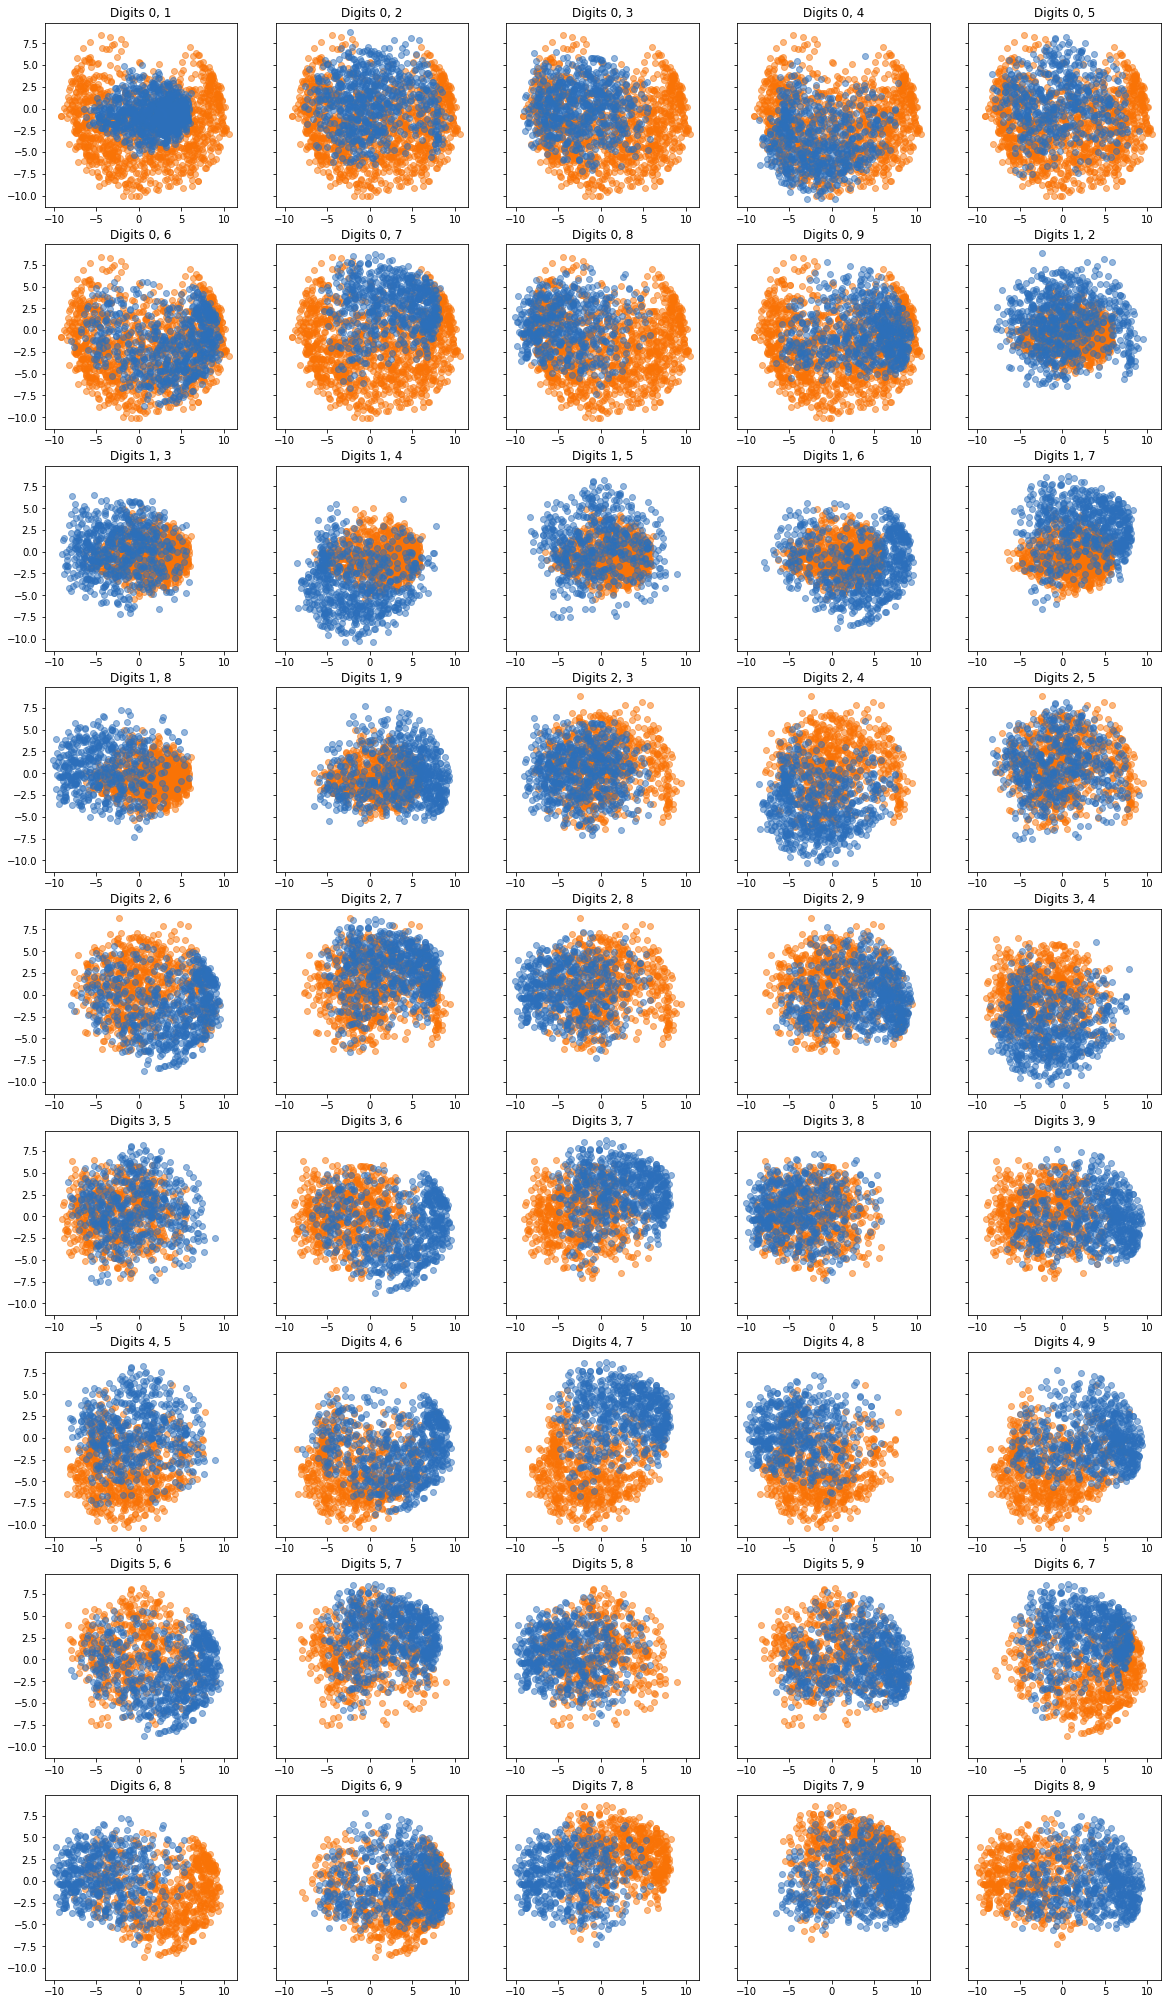

In [146]:
pairs = [(i,j) for i in range(10) for j in range(i+1,10)]
pairit = iter(pairs)
data = np.vstack(train_reduced)
xmin, xmax = np.min(data[:,0]), np.max(data[:,0])
ymin, ymax = np.min(data[:,1]), np.max(data[:,1])

fig, subplt = plt.subplots(9, 5, sharey=True, figsize=(4*5,4*9))
for sub in fig.axes:
        i, j = next(pairit)
        sub.set_xlim(np.real([xmin-1, xmax+1]))
        sub.set_ylim(np.real([ymin-1, ymax+1]))
        sub.plot(np.real(train_reduced[i][:,0]), np.real(train_reduced[i][:,1]), 'o', color='xkcd:orange', alpha=0.5)
        sub.plot(np.real(train_reduced[j][:,0]), np.real(train_reduced[j][:,1]), 'o', color='xkcd:medium blue', alpha=0.5)
        sub.set_title('Digits ' + str(i) + ', ' + str(j))


# Exercise 2

For this exercise, we use the facial data from the lfwcrop-datset (see http://conradsanderson.id.au/lfwcrop/). For the exercise, we downloaded the .zip folder <font color='#0af'>lfwcrop_grey.zip</font>, and extracted it to a a selected directory. The obtained folder contains a subfolder <font color='#0af'>faces</font>, which contains several .pgm files featuring the cropped facial images of several people.

In [149]:
import os
from PIL import Image
data = []
folderpath = '../lfwcrop_grey/faces/'
files = os.listdir(folderpath)
for filename in files:
    if(filename.endswith('.pgm')):
        img = Image.open(folderpath + filename)
        data.append(np.array(img).flatten())
data = np.vstack(data)

To be sure that the data makes sense, we first perform a greyscale plot of the first data file from the set:

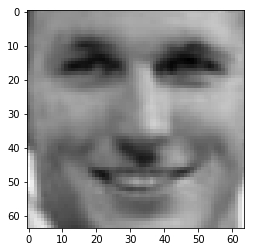

In [18]:
visualize(data, 0, shape=[64,64])

In [150]:
%time eigvals, eigvecs, data_red = PCA([data], selmethod=0, ret=True)

Wall time: 1min 10s


First of all, we plot the eigenvalues. Typically, there is an exponentiall falloff for the absolute values of the eigenvalues. Thus we plot the logarithmic values to allow all data points to be neatly plotted:

<Container object of 1000 artists>

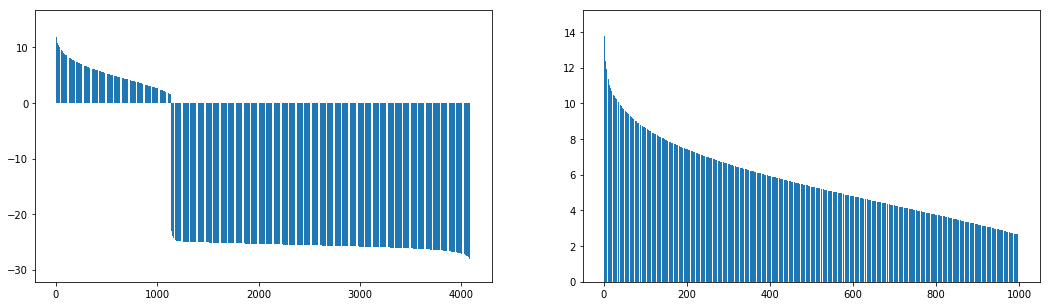

In [151]:
eigvals_abs = np.abs(eigvals)
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(2*9,5))
plot1.bar(range(len(eigvals)), np.log(eigvals_abs))
plot2.bar(range(1000), np.log(eigvals_abs[:1000]))

Note that we are plotting the logarithmic values, so for exponentially decreasing eigenvalues, we would expect a straight line with a certain incline. However, for approximately the first 100 eigenvalues, the we do not get a straight line but rather a hyperbolic shape, which suggests that decrease is even superexponentional for the first eigenvalues. Then, after the first 100 eigenvalues, we do indeed get a straight line. Beyond the first 1000, the eigenvalues are so small that their logarithmic values become negative.

Summing up, it is clear that only a fraction of the eigenvalues and their respective eigenvectors are truly relevant for the feature space. But how should we settle for a number of eigenvalues to pick? A possiblity may be using the elbow method, but we would like to propose a different approach, namely taking the first $n$ eigenvalues, such that the sum of those eigenvalues becomes a sufficiently high fraction $\alpha  \in (0,1)$ of the sum over the absolute eigenvalues. If you think of the eigenvalues as plotted above, the intuition behind this approach is to cut a slice such that the area below the curve of descending eigenvalues is as big and the length of the slice as small as possible.

Unsurprisingly, even for reasonably small eigenvalue numbers, the ratios $\alpha$ obtained are quite high:

In [152]:
eigvals_abs = np.abs(eigvals)
eigval_sum = np.sum(eigvals_abs)
sum_ = 0
slices = []
ratios = list(np.arange(0.5,1.0,0.05)) + [0.99]

i = 0
for r  in ratios:
    while(sum_ < r *eigval_sum):
        sum_ += eigvals_abs[i]
        i += 1
    slices.append(i)
    
html = pd.DataFrame(np.array(slices)[np.newaxis,:], index=['n'], columns=[str(100*r) + '%' for r in ratios]).to_html()
display(HTML(html))

,50.0%,55.0%,60.0%,65.0%,70.0%,75.0%,80.0%,85.0%,90.0%,95.0%,99.0%
n,4,5,7,10,14,21,31,48,78,148,392


We already ran the PCA using the above method for a ratio of 95%. However, for practical reasons, we will restrict ourselves to ploting only the first 30 eigenfaces.

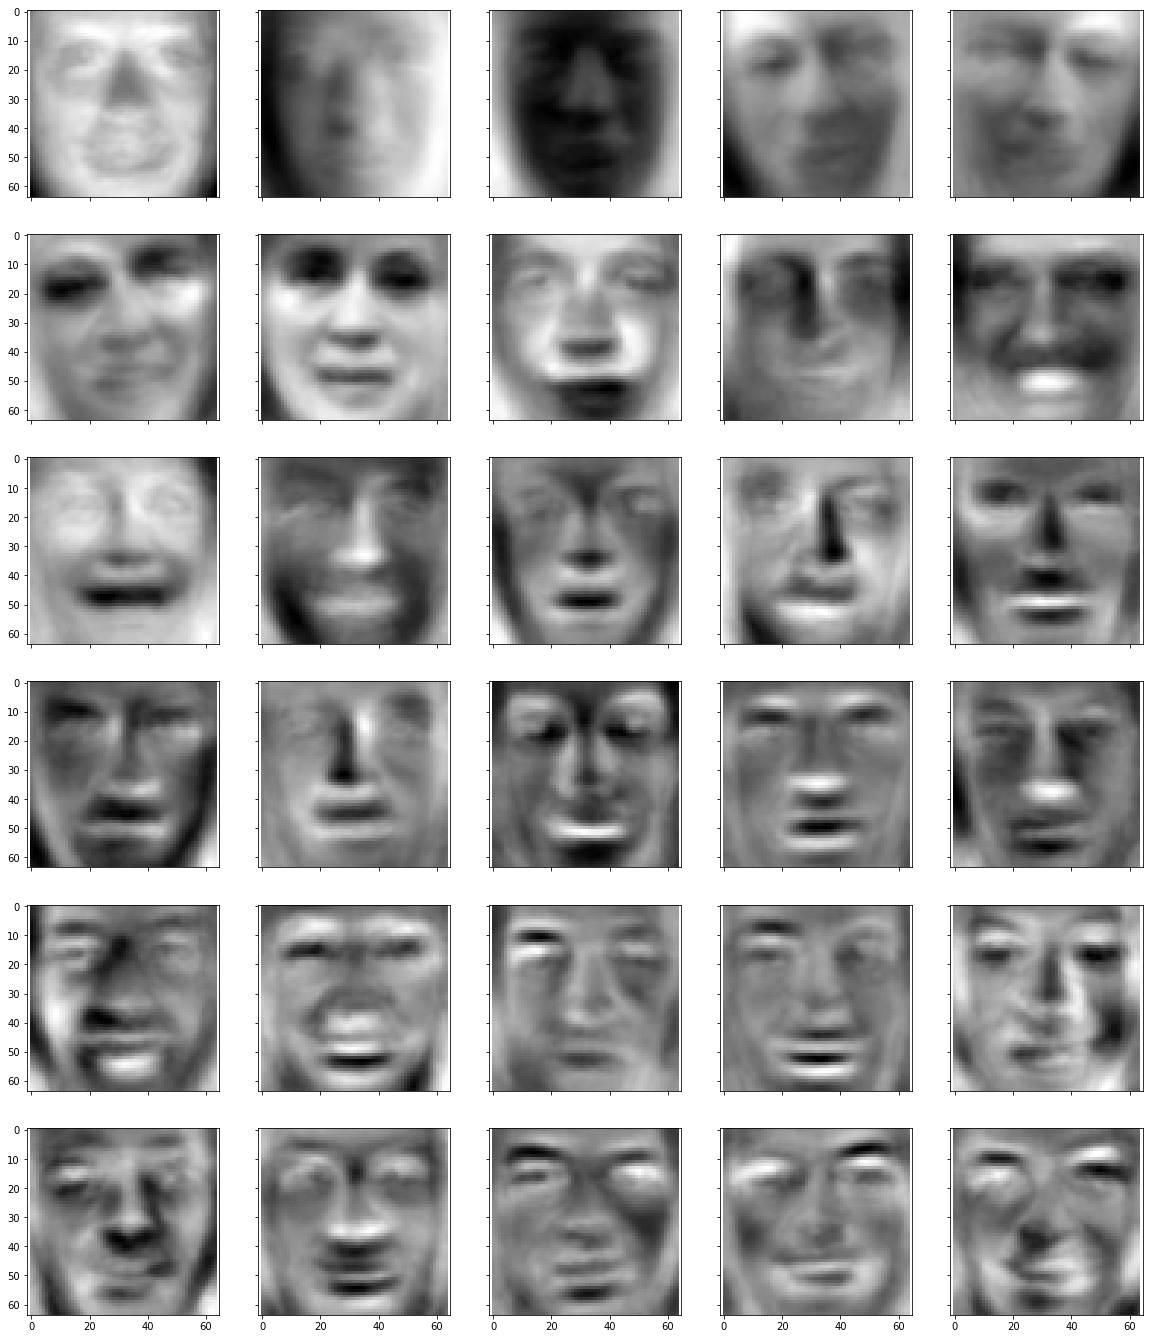

In [154]:
fig, subplt = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(4*5, 4*6))
i = 0
for sub in fig.axes:
    v = data[0].astype('float')
    v_proj = np.dot(np.outer(eigvecs[:,i], eigvecs[:,i]), v).reshape([64,64])
    sub.imshow(np.real(v_proj))
    i += 1